## DataLoader & Leaderboard

[Tianfan Fu@Gatech](futianfan.github.io)


Agenda

- dataloader
    - `single_pred`
    - `multi_pred`
    - `generation`
    - demo
        - scikit-learn demo
        - deeppurpose demo
- leaderboard
    - ADMET leaderboard
    - DTI leaderboard


Let's start!


### DataLoader

Supposed a dataset X is from therapeutic task Y with machine learning problem Z, then to obtain the data and splits, simply type:



```python
from tdc.Z import Y
data = Y(name = 'X')
split = data.split()
```

Z can be 
- `single_pred`
- `multi_pred`
- `generation`

The circle can be small molecule, protein. 

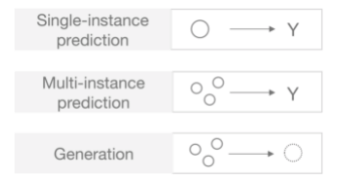

#### `single_pred`: Prediction of property for an individual biomedical entity.

In [22]:
from tdc.single_pred import ADME
data = ADME(name = 'Caco2_Wang', convert_format = 'DGL')

Found local copy...
Loading...
Done!


#### `multi_pred`: Prediction of property for multiple biomedical entities.

In [23]:
from tdc.multi_pred import PPI
data = PPI(name = 'HuRI')
split = data.get_split()
split['valid'].head(2)

Found local copy...
Loading...
Done!


,Protein1_ID,Protein1,Protein2_ID,Protein2,Y
0,ENSG00000102119,MDNYADLSDTELTTLLRRYNIPHGPVVDLNSTRGDADMYDLPKKED...,ENSG00000176435,MRPAFALCLLWQALWPGPGGGEHPTADRAGCSASGACYSLHHATMK...,1
1,ENSG00000157110,MNNGGKAEKENTPSEANLQEEEVRTLFVSGLPLDIKPRELYLLFRP...,ENSG00000227151,MEEPRPSKRLRSMAPNQASGGPPPEPGCCVADPEGSVEADGPAQPA...,1


#### `generation`: Generation of a new desirable biomedical entity.

In [24]:
from tdc.generation import MolGen
data = MolGen(name = 'MOSES')
split = data.get_split()
split['train'].head(2)

Found local copy...
Loading...
Done!


,smiles
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1


In [25]:
from tdc.generation import RetroSyn
data = RetroSyn(name = 'USPTO-50K')
split = data.get_split()
split['train'].head(2)

Found local copy...
Loading...
Done!


,input,output
0,COC(=O)CCC(=O)c1ccc(OC2CCCCO2)cc1O,C1=COCCC1.COC(=O)CCC(=O)c1ccc(O)cc1O
1,COC(=O)c1cccc(-c2nc3cccnc3[nH]2)c1,COC(=O)c1cccc(C(=O)O)c1.Nc1cccnc1N


### ML-ready example (I): Scikit-learn



In [26]:
data = ADME(name = 'HIA_Hou', convert_format='ECFP2').get_data(format = 'dict')
X, y = data['Drug_ECFP2'], data['Y']

Found local copy...
Loading...
Done!


In [27]:
import numpy as np
from tdc.single_pred import ADME
data = ADME(name = 'HIA_Hou', convert_format='ECFP2').get_data(format = 'dict')
X, y = data['Drug_ECFP2'], data['Y']

from sklearn.model_selection import train_test_split
X, y = np.concatenate([i.reshape(1,-1) for i in X], 0), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    stratify=y,
                                                    test_size=0.1)

### use tdc data split


Found local copy...
Loading...
Done!


[model=One versus Rest, solver=saga] Number of epochs: 1
[model=One versus Rest, solver=saga] Number of epochs: 3
Test accuracy for model ovr: 0.8966
% non-zero coefficients for model ovr, per class:
 [20.55664062]
Run time (3 epochs) for model ovr:0.12
[model=Multinomial, solver=saga] Number of epochs: 1
[model=Multinomial, solver=saga] Number of epochs: 3
[model=Multinomial, solver=saga] Number of epochs: 7
Test accuracy for model multinomial: 0.9310
% non-zero coefficients for model multinomial, per class:
 [10.20507812]
Run time (7 epochs) for model multinomial:0.38
Example run in 1.111 s


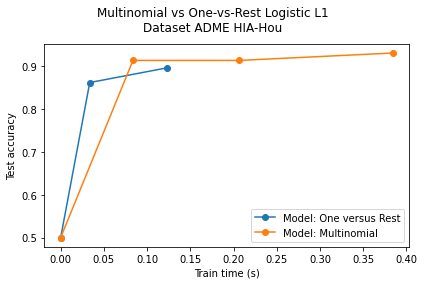

In [28]:
import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

t0 = time.clock()
solver = 'saga'
train_samples, n_features = X_train.shape
n_classes = np.unique(y).shape[0]
models = {'ovr': {'name': 'One versus Rest', 'iters': [1, 3]},
          'multinomial': {'name': 'Multinomial', 'iters': [1, 3, 7]}}

for model in models:
    # Add initial chance-level values for plotting purpose
    accuracies = [1 / n_classes]
    times = [0]
    densities = [1]

    model_params = models[model]

    for this_max_iter in model_params['iters']:
        print('[model=%s, solver=%s] Number of epochs: %s' %
              (model_params['name'], solver, this_max_iter))
        lr = LogisticRegression(solver=solver,
                                multi_class=model,
                                C=1,
                                penalty='l1',
                                fit_intercept=True,
                                max_iter=this_max_iter,
                                random_state=42,
                                )
        t1 = time.clock()
        lr.fit(X_train, y_train)
        train_time = time.clock() - t1

        y_pred = lr.predict(X_test)
        accuracy = np.sum(y_pred == y_test) / y_test.shape[0]
        density = np.mean(lr.coef_ != 0, axis=1) * 100
        accuracies.append(accuracy)
        densities.append(density)
        times.append(train_time)
    models[model]['times'] = times
    models[model]['densities'] = densities
    models[model]['accuracies'] = accuracies
    print('Test accuracy for model %s: %.4f' % (model, accuracies[-1]))
    print('%% non-zero coefficients for model %s, '
          'per class:\n %s' % (model, densities[-1]))
    print('Run time (%i epochs) for model %s:'
          '%.2f' % (model_params['iters'][-1], model, times[-1]))

fig = plt.figure()
ax = fig.add_subplot(111)

for model in models:
    name = models[model]['name']
    times = models[model]['times']
    accuracies = models[model]['accuracies']
    ax.plot(times, accuracies, marker='o',
            label='Model: %s' % name)
    ax.set_xlabel('Train time (s)')
    ax.set_ylabel('Test accuracy')
ax.legend()
fig.suptitle('Multinomial vs One-vs-Rest Logistic L1\n'
             'Dataset %s' % 'ADME HIA-Hou')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
run_time = time.clock() - t0
print('Example run in %.3f s' % run_time)
plt.show()

### ML-ready example (II): DeepPurpose

DeepPurpose is a scikit learn style Deep Learning Based Molecular Modeling and Prediction Toolkit on Drug-Target Interaction Prediction, Compound Property Prediction, Protein-Protein Interaction Prediction, and Protein Function prediction. Using DeepPurpose, we can rapidly build model prototypes for various drug discovery tasks covered in TDC, such as ADME, Tox, HTS, Developability prediction, DTI, DDI, PPI, Antibody Affinity predictions. 

Note that DeepPurpose is developed by two of the core teams in TDC, Kexin and Tianfan, and it is now published in Bioinformatics. To start with this tutorial, please follow [DeepPurpose instructions](https://github.com/kexinhuang12345/DeepPurpose#install--usage) to set up the necessary packages. DeepPurpose also provides [tutorials](https://github.com/kexinhuang12345/DeepPurpose/blob/master/Tutorial_1_DTI_Prediction.ipynb) for you to familiarize with it. 

### DeepPurpose Installation

```bash
conda create -n DeepPurpose python=3.6
conda activate DeepPurpose
conda install -c conda-forge rdkit
pip install git+https://github.com/bp-kelley/descriptastorus 
pip install DeepPurpose
pip install PyTDC --upgrade
```


We assume now you have set up the right environment. Now, we show you how to build an ADME predictor using Message Passing Neural Network (MPNN)! 

### Predicting HIA using MPNN with 10 Lines of Code

First, let's load DeepPurpose and TDC:

In [29]:
from DeepPurpose import utils, CompoundPred
from tdc.single_pred import ADME

Now, you can get the HIA dataset from TDC. HIA is from ADME task from Single-instance prediction and we want to predict whether or not can a compound be absorped in human intestinal, i.e. given SMILES X, predict 1/0. Note that for drug property prediction, DeepPurpose takes in an array of drug SMILES string and an array of labels. You could access that directly by setting the `get_data(format = 'dict')`:

In [30]:
data = ADME(name = 'HIA_Hou', convert_format='DGL').get_data(format = 'dict')
X, y = data['Drug'], data['Y']

Found local copy...
Loading...
Done!


 We also provide a DeepPurpose format, where you can directly get the correct input data:

In [31]:
X, y = ADME(name = 'HIA_Hou', convert_format = 'DGL').get_data(format = 'DeepPurpose')

Found local copy...
Loading...
Done!


DeepPurpose provides 8 encoders for compound, ranging from MLP on classic cheminformatics fingerprint such as Morgan, RDKit2D to deep learning models such as CNN, transformer, and MPNN. To specify the encoder, simply types the encoder name. Here, we use MPNN as an example:

Now, we encode the data into the specified format, using `utils.data_process` function. It specifies train/validation/test split fractions, and random seed to ensure same data splits for reproducibility. **We have made DeepPurpose to accomodate the TDC benchmark split.** Simply type 'TDC' in the random seed will generate the same split as in TDC split function. The function outputs train, val, test pandas dataframes.

In [32]:
drug_encoding = 'MPNN'
train, val, test = utils.data_process(X_drug = X, 
                                      y = y, 
                                      drug_encoding = drug_encoding,
                                      random_seed = 'TDC')

Drug Property Prediction Mode...
in total: 578 drugs
encoding drug...
unique drugs: 578
Done.


In [33]:
train.head(2)

,SMILES,Label,drug_encoding
0,CC(=O)Nc1ccccc1,1,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."
1,CC(=O)Nc1nnc(S(N)(=O)=O)s1,1,"[[[tensor(1.), tensor(0.), tensor(0.), tensor(..."


Build and train model within 4 lines of code, in less than 1 minute. 

Let's use CPU/s!
--- Data Preparation ---
--- Go for Training ---
Training at Epoch 1 iteration 0 with loss 0.69110. Total time 0.0 hours
Validation at Epoch 1 , AUROC: 0.54621 , AUPRC: 0.92104 , F1: 0.93577
Training at Epoch 2 iteration 0 with loss 0.47158. Total time 0.00083 hours
Validation at Epoch 2 , AUROC: 0.61624 , AUPRC: 0.90770 , F1: 0.93577
Training at Epoch 3 iteration 0 with loss 0.38406. Total time 0.00166 hours
Validation at Epoch 3 , AUROC: 0.39775 , AUPRC: 0.82919 , F1: 0.93577
--- Go for Testing ---
Testing AUROC: 0.5425742574257426 , AUPRC: 0.9045766029111401 , F1: 0.9308755760368664
--- Training Finished ---


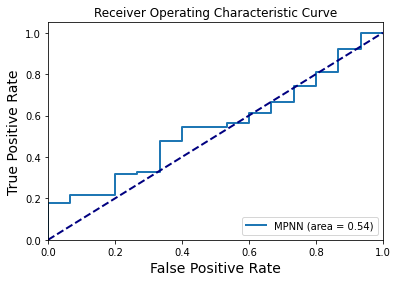

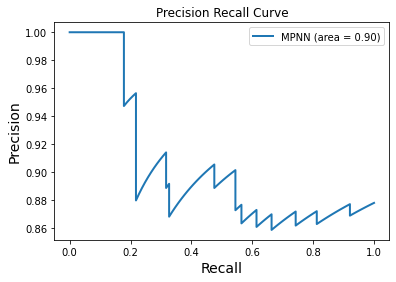

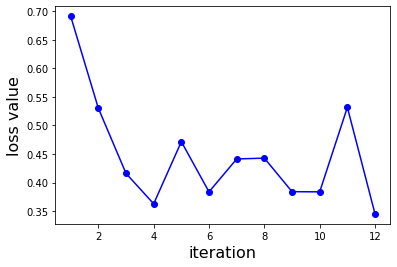

In [34]:
config = utils.generate_config(drug_encoding = drug_encoding, 
                               train_epoch = 3, 
                               LR = 0.001, 
                               batch_size = 128,
                               mpnn_hidden_size = 32,
                               mpnn_depth = 2)
model = CompoundPred.model_initialize(**config)
model.train(train, val, test)
model.save_model('./tutorial_model')

## ADMET leaderboard

ADMET is a cornerstone of small molecule drug discovery, defining drug efficacy and toxicity profile. An ML model that could accurately predict all ADMET properties using structural information of compounds would be greatly valuable.
We formulate the ADMET Benchmark Group using 22 ADMET datasets in TDC. 


In [35]:
from rdkit.DataStructs import cDataStructs
from DeepPurpose import CompoundPred as models
from DeepPurpose.utils import *

from tdc import BenchmarkGroup
group = BenchmarkGroup(name = 'ADMET_Group', path = 'data/')

import warnings
warnings.filterwarnings("ignore")

drug_encoding = 'DGL_NeuralFP'


seed = 1
predictions = {}
benchmark = group.get('Caco2_Wang')

train, valid = group.get_train_valid_split(benchmark = benchmark['name'], split_type = 'default', seed = seed)

train = data_process(X_drug = train.Drug.values, y = train.Y.values, 
                        drug_encoding = drug_encoding,
                        split_method='no_split')
val = data_process(X_drug = valid.Drug.values, y = valid.Y.values, 
                        drug_encoding = drug_encoding,
                        split_method='no_split')
test = data_process(X_drug = benchmark['test'].Drug.values, y = benchmark['test'].Y.values, 
                        drug_encoding = drug_encoding,
                        split_method='no_split')

config = generate_config(drug_encoding = drug_encoding, 
                                 cls_hidden_dims = [512], 
                                 train_epoch = 5, 
                                 LR = 0.001, 
                                 batch_size = 128,
                                )

model = models.model_initialize(**config)
model.train(train, val, test, verbose = False)
y_pred = model.predict(test)
predictions[benchmark['name']] = y_pred

group.evaluate(predictions)


tdc.BenchmarkGroup will be deprecated soon. Please use tdc.benchmark_group.XXX_group and check out the examples on website!
Found local copy...
generating training, validation splits...
100%|███████████████████████████████████████████| 728/728 [00:00<00:00, 730.70it/s]


Drug Property Prediction Mode...
in total: 637 drugs
encoding drug...
unique drugs: 634
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 91 drugs
encoding drug...
unique drugs: 91
do not do train/test split on the data for already splitted data
Drug Property Prediction Mode...
in total: 182 drugs
encoding drug...
unique drugs: 181
do not do train/test split on the data for already splitted data
predicting...


{'caco2_wang': {'mae': 1.364}}

## DTI Leaderboard 

Drug-target interaction (**DTI**) measures the binding of drug molecules to the protein targets. 
Accurate identification of DTI is fundamental for drug discovery and supports many downstream tasks.

In [36]:
from tdc import BenchmarkGroup
group = BenchmarkGroup(name = 'DTI_DG_Group', path = './data')





tdc.BenchmarkGroup will be deprecated soon. Please use tdc.benchmark_group.XXX_group and check out the examples on website!
Found local copy...
